In [1]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal

In [2]:
from PIL import Image
from torchvision.transforms import ToTensor
import torch

In [13]:
import os

def _parse_binary_fname(fname,lastidx=None, dtype = 'uint16', shape = None, sep = '_'):
    '''
    Gets the data type and the shape from the filename 
    This is a helper function to use in load_dat.
    
    out = _parse_binary_fname(fname)
    
    With out default to: 
        out = dict(dtype=dtype, shape = shape, fnum = None)
    '''
    fn = os.path.splitext(os.path.basename(fname))[0]
    fnsplit = fn.split(sep)
    fnum = None
    if lastidx is None:
        # find the datatype first (that is the first dtype string from last)
        lastidx = -1
        idx = np.where([not f.isnumeric() for f in fnsplit])[0]
        for i in idx[::-1]:
            try:
                dtype = np.dtype(fnsplit[i])
                lastidx = i
            except TypeError:
                pass
    if dtype is None:
        dtype = np.dtype(fnsplit[lastidx])
    # further split in those before and after lastidx
    before = [f for f in fnsplit[:lastidx] if f.isdigit()]
    after = [f for f in fnsplit[lastidx:] if f.isdigit()]
    if shape is None:
        # then the shape are the last 3
        shape = [int(t) for t in before[-3:]]
    if len(after)>0:
        fnum = [int(t) for t in after]
    return dtype,shape,fnum

def load_dat(filename,
             nframes = None,
             offset = 0,
             shape = None,
             dtype='uint16'): 
    '''
    Loads frames from a binary file.
    
    Inputs:
        filename (str)       : fileformat convention, file ends in _NCHANNELS_H_W_DTYPE.dat
        nframes (int)        : number of frames to read (default is None: the entire file)
        offset (int)         : offset frame number (default 0)
        shape (list|tuple)   : dimensions (NCHANNELS, HEIGHT, WIDTH) default is None
        dtype (str)          : datatype (default uint16) 
    Returns:
        An array with size (NFRAMES,NCHANNELS, HEIGHT, WIDTH).

    Example:
        dat = load_dat(filename)
        
    ''' 
    if not os.path.isfile(filename):
        raise OSError('File {0} not found.'.format(filename))
    if shape is None or dtype is None: # try to get it from the filename
        dtype,shape,_ = _parse_binary_fname(filename,
                                            shape = shape,
                                            dtype = dtype)
    if type(dtype) is str:
        dt = np.dtype(dtype)
    else:
        dt = dtype

    if nframes is None:
        # Get the number of samples from the file size
        nframes = int(os.path.getsize(filename)/(np.prod(shape)*dt.itemsize))
    framesize = int(np.prod(shape))

    offset = int(offset)
    with open(filename,'rb') as fd:
        fd.seek(offset*framesize*int(dt.itemsize))
        buf = np.fromfile(fd,dtype = dt, count=framesize*nframes)
    buf = buf.reshape((-1,*shape),
                      order='C')
    return buf

In [3]:
path = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-4-1L/24-Nov-2023_1/"
file_name = 'Frames_1_640_540_uint16_000{}.dat'.format(2)

In [5]:
def get_data_location(path, file_num):
    #file_name = 'Frames_1_640_540_uint16_000{}.dat'.format(file_num)
    path_azimuth_LR = path + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num)
    path_azimuth_RL = path + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num + 1)
    path_elevation_UD = path + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num + 2)
    path_elevation_DU = path + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num + 3)
    return path_azimuth_LR, path_azimuth_RL, path_elevation_UD, path_elevation_DU

path_azimuth_LR, path_azimuth_RL, path_elevation_UD, path_elevation_DU = get_data_location(path, 2)

'/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-4-1L/24-Nov-2023_1/Frames_1_640_540_uint16_0002.dat'

In [104]:
path_azimuth_LR = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-4-1L/24-Nov-2023_1/Frames_1_640_540_uint16_0002.dat"
path_azimuth_RL = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-4-1L/24-Nov-2023_1/Frames_1_640_540_uint16_0003.dat"

path_elevation_UD = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-4-1L/24-Nov-2023_1/Frames_1_640_540_uint16_0004.dat"
path_elevation_DU = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-4-1L/24-Nov-2023_1/Frames_1_640_540_uint16_0005.dat"

def create_tensor_from_dat(filename):
    np_stack = load_dat(filename)
    np_stack = np.array(np_stack, dtype=np.float32)
    np_stack.transpose(0,1,3,2)
    tensor_stack = torch.from_numpy(np_stack).unsqueeze(1).float()
    tensor_470 = tensor_stack[:,0,0,150:450,150:450]
    return tensor_470

def create_tensor_from_tif(path):
    tiff_stack = Image.open(path)
    # Step 2: Pre-allocate a NumPy array based on the number of frames and the dimensions of each frame
    # Replace with the actual number of frames and dimensions for your dataset
    num_frames = 900  # Total number of frames
    height = 540       # Height of each frame
    width = 640        # Width of each frame

    # Initialize an empty NumPy array
    np_stack = np.empty((num_frames, height, width), dtype=np.float32)  # or dtype=np.float32 if needed

    # Step 3: Read and insert each frame into the pre-allocated array
    for i in range(num_frames):
        np_stack[i, :, :] = np.array(tiff_stack, dtype=np.float32)
        try:
            tiff_stack.seek(tiff_stack.tell() + 1)
        except EOFError:
            break  # If there are no more frames

    # Close the file
    tiff_stack.close()

    # Step 4: Convert to a PyTorch tensor
    tensor_stack = torch.from_numpy(np_stack).unsqueeze(1).float()
    tensor_470 = tensor_stack[:,0,150:450,150:450]
    return tensor_stack, tensor_470

In [106]:
tensor_azimuthLR = create_tensor_from_dat(path_azimuth_LR)
tensor_azimuthRL = create_tensor_from_dat(path_azimuth_RL)

tensor_elevationUD = create_tensor_from_dat(path_elevation_UD)
tensor_elevationDU = create_tensor_from_dat(path_elevation_DU)

In [152]:
tensor_azimuth = (tensor_azimuth1 - tensor_azimuth2)
tensor_elevation = (tensor_elevation1 - tensor_elevation2)


In [1]:
tensor_azimuth = tensor_azimuth2
tensor_elevation = tensor_azimuth1


NameError: name 'tensor_azimuth2' is not defined

In [223]:
def create_stimulus_corrected_movie_pt(tensor, baseline_start, baseline_end):
    """
    Correct the movie by subtracting the mean of frames before the start of stimulation in PyTorch.

    Args:
    tensor (torch.Tensor): A 3D tensor representing the movie data (time x width x height).
    baseline_start (int): The start frame of the baseline period.
    baseline_end (int): The end frame of the baseline period.

    Returns:
    torch.Tensor: A 3D tensor representing the corrected movie.
    """
    # Calculate the baseline mean
    baseline_mean = tensor[baseline_start:baseline_end, :, :].mean(dim=0)

    # Subtract the baseline mean from all frames
    corrected_movie = tensor - baseline_mean

    return corrected_movie

def extract_first_harmonic_phase(data, peak_frequency, bandwidth, sample_rate):
    """
    Extract the phase of the first harmonic component within a specific frequency band.

    Args:
    data (torch.Tensor): A 3D tensor representing the data (time x width x height).
    peak_frequency (float): Peak frequency for the Fourier transform.
    bandwidth (tuple): The frequency band (low, high).
    sample_rate (float): The sampling rate of the data.

    Returns:
    torch.Tensor: A 2D tensor representing the phase map.
    """
    # Fourier transform
    ft_data = torch.fft.fftn(data, dim=[0])

    # Frequency resolution
    freq_resolution = torch.fft.fftfreq(data.size(0), d=1.0/sample_rate)

    # Find indices within the specified bandwidth
    bandwidth_indices = (freq_resolution >= bandwidth[0]) & (freq_resolution <= bandwidth[1])

    # Extract the first harmonic within the bandwidth
    first_harmonic_band = ft_data[bandwidth_indices, :, :]

    # Calculate the phase of the first harmonic
    phase_map = torch.angle(first_harmonic_band)

    return phase_map

In [224]:
tensor_azimuth.shape

torch.Size([905, 300, 300])

In [225]:
corrected_movie_az = create_stimulus_corrected_movie_pt(tensor_azimuth, 0, 60)
corrected_movie_elev = create_stimulus_corrected_movie_pt(tensor_elevation, 0, 60)

In [226]:
def get_phase_map(corrected_movie, sample_rate, peak_freq):
    calcium_data = corrected_movie
    #sample_rate = 30.0
    #peak_freq = 0.043
    min_band = peak_freq - peak_freq/2
    max_band = peak_freq + peak_freq/2
    phase_map = extract_first_harmonic_phase(calcium_data, peak_freq, (min_band, max_band), sample_rate)
    return phase_map

phase_map_az = get_phase_map(corrected_movie_az[65:714], 30.0, 0.043)
phase_map_elev = get_phase_map(corrected_movie_elev[54:648], 30.0, 0.048)

In [227]:
import math

def visualSignMap(phasemap1, phasemap2):
    """
    calculate visual sign map from two orthogonally oriented phase maps
    """

    if phasemap1.shape != phasemap2.shape:
        raise LookupError("'phasemap1' and 'phasemap2' should have same size.")

    gradmap1 = np.gradient(phasemap1)
    gradmap2 = np.gradient(phasemap2)

    # gradmap1 = ni.filters.median_filter(gradmap1,100.)
    # gradmap2 = ni.filters.median_filter(gradmap2,100.)

    graddir1 = np.zeros(np.shape(gradmap1[0]))
    # gradmag1 = np.zeros(np.shape(gradmap1[0]))

    graddir2 = np.zeros(np.shape(gradmap2[0]))
    # gradmag2 = np.zeros(np.shape(gradmap2[0]))

    for i in range(phasemap1.shape[0]):
        for j in range(phasemap2.shape[1]):
            graddir1[i, j] = math.atan2(gradmap1[1][i, j], gradmap1[0][i, j])
            graddir2[i, j] = math.atan2(gradmap2[1][i, j], gradmap2[0][i, j])

            # gradmag1[i,j] = np.sqrt((gradmap1[1][i,j]**2)+(gradmap1[0][i,j]**2))
            # gradmag2[i,j] = np.sqrt((gradmap2[1][i,j]**2)+(gradmap2[0][i,j]**2))

    vdiff = np.multiply(np.exp(1j * graddir1), np.exp(-1j * graddir2))

    areamap = np.sin(np.angle(vdiff))

    return areamap

In [228]:
visual_field_map = visualSignMap(phase_map_az[0], phase_map_elev[0])

In [229]:
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing, binary_dilation, label
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
import scipy.ndimage as ndi

def process_visual_field_sign_map(vf_sign_map, std_dev_range=(6, 10), threshold_range=(0.2, 0.4), min_patch_size=30):
    """
    Process the visual field sign map to create a 'raw' patch map.

    Args:
    vf_sign_map (numpy.ndarray): A 2D array representing the visual field sign map.
    std_dev_range (tuple): The range of standard deviations for the Gaussian filter.
    threshold_range (tuple): The range of threshold values for creating the binary mask.
    min_patch_size (int): The minimum size of patches to be retained.

    Returns:
    numpy.ndarray: A 2D array representing the processed 'raw' patch map.
    """
    # Gaussian filtering
    mean_std_dev = np.mean(std_dev_range)
    filtered_map = gaussian_filter(vf_sign_map, sigma=mean_std_dev)

    # Thresholding to create a binary mask
    threshold = np.mean(threshold_range)
    binary_map = (filtered_map > threshold).astype(int)

    # Dilation, Opening and Closing operations
    dilated_map = binary_dilation(binary_map)
    opened_map = binary_opening(dilated_map)
    closed_map = binary_closing(opened_map)

    # Label connected components
    labeled_map, _ = label(closed_map)

    # Remove small objects
    cleaned_map = remove_small_objects(labeled_map, min_size=min_patch_size)

    # Create raw patch map with sign values (-1, 0, 1)
    raw_patch_map = np.sign(cleaned_map)

    return filtered_map, labeled_map, raw_patch_map

# Example usage (assuming vf_sign_map is your visual field sign map):
# processed_map = process_visual_field_sign_map(vf_sign_map)
# This will create a processed 'raw' patch map based on the visual field sign map.

processed_map = process_visual_field_sign_map(visual_field_map)[0]


In [230]:
phase_map_az.max()

tensor(3.1416)

In [6]:
def rotation(image):
    rotated_image = np.rot90(image)
    flipped_image = np.flipud(rotated_image)
    return flipped_image

In [7]:
from scipy.ndimage import gaussian_filter

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)


axs[0].imshow(rotation(tensor_azimuth.mean(axis=0)))
axs[0].set_title("vasculature")
axs[0].axis('off')

axs[1].imshow(rotation(gaussian_filter(phase_map_az[0], sigma=std_dev_range)), cmap='hsv')
axs[1].set_title("azimuth")
axs[1].axis('off')

axs[2].imshow(rotation(gaussian_filter(phase_map_elev[0], sigma=std_dev_range)), cmap='hsv')
axs[2].set_title("altitude")
axs[2].axis('off')

axs[3].imshow(rotation(gaussian_filter(visual_field_map, sigma=mean_std_dev)), cmap='jet', clim=[-0.15,0.15])
axs[3].set_title("visual field map")
axs[3].axis('off')



NameError: name 'plt' is not defined

(-0.5, 299.5, 299.5, -0.5)

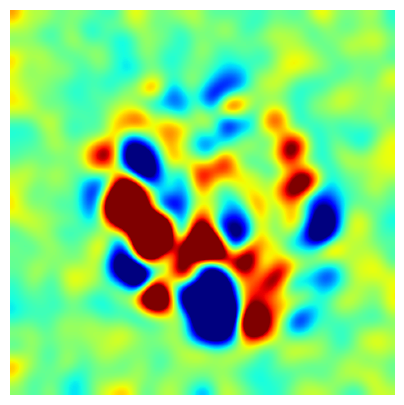

In [235]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.imshow(gaussian_filter(rotation(visual_field_map), sigma=8), cmap='jet', clim=[-0.15,0.15])
#axs.set_title("visual field map")
axs.axis('off')

(-0.5, 299.5, 299.5, -0.5)

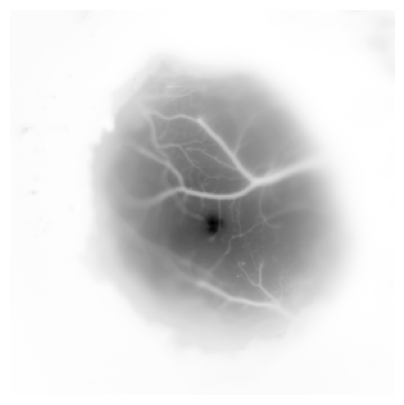

In [233]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.imshow(rotation(tensor_azimuth.mean(axis=0)), cmap="binary")
#axs.set_title("visual field map")
axs.axis('off')